[View in Colaboratory](https://colab.research.google.com/github/Masum06/gender_newspaper/blob/master/char_rnn_newspaper.ipynb)

https://colab.research.google.com/drive/1kF8m15c6lr4bqfnPMja0zXjFlvDo7z4i



**Description:**

*   Create a character based RNN gender recognizer from the 3 million name data
*   Take the 600MB newspaper crawled data as input
*   Keep only the national news
*   Create 4 datasets from the newspaper data, 
*   Save them in drive, to later make word vectors with each dataset



# Download Data
Run either 1 or 2

### 1. Connect to Google drive

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
ls -l drive/data/

total 700503
drwxr-xr-x 2 root root      4096 Aug  7 04:58 archived/
-rw-r--r-- 1 root root      1954 Aug  6 13:04 cse13_names.txt
-rw-r--r-- 1 root root  58668225 Aug  6 15:36 hsc_unique.csv
-rw-r--r-- 1 root root     27174 Aug  6 08:48 news_db_instance.json
-rw-r--r-- 1 root root 658608032 Aug  6 08:49 news_db.json
drwxr-xr-x 2 root root      4096 Aug  6 15:33 newspaper_text/


In [3]:
!cp drive/data/* ./

cp: -r not specified; omitting directory 'drive/data/archived'
cp: -r not specified; omitting directory 'drive/data/newspaper_text'


In [5]:
ls -l

total 700516
-rw-r--r-- 1 root root      1954 Aug  7 18:27 cse13_names.txt
drwxr-xr-x 1 root root      4096 Aug  7 18:26 datalab/
drwxr-xr-x 2 root root      4096 Aug  7 18:26 drive/
-rw-r--r-- 1 root root  58668225 Aug  7 18:27 hsc_unique.csv
-rw-r--r-- 1 root root     27174 Aug  7 18:27 news_db_instance.json
-rw-r--r-- 1 root root 658608032 Aug  7 18:27 news_db.json


### 2. Down From Mega

In [4]:
%%bash
git clone https://github.com/jeroenmeulenaar/python3-mega.git python3mega
cd python3mega
pip install -r requirements.txt

  Running setup.py bdist_wheel for URLObject: started
  Running setup.py bdist_wheel for URLObject: finished with status 'done'
  Stored in directory: /content/.cache/pip/wheels/fd/7e/18/ccb55ecc2834f945b769c1ff1df12ca5a14400ccfc58e3c515
  Running setup.py bdist_wheel for pycrypto: started
  Running setup.py bdist_wheel for pycrypto: finished with status 'done'
  Stored in directory: /content/.cache/pip/wheels/27/02/5e/77a69d0c16bb63c6ed32f5386f33a2809c94bd5414a2f6c196
Successfully built URLObject pycrypto


Cloning into 'python3mega'...


In [0]:
import os
os.chdir('python3mega')
from mega import Mega
m = Mega.from_ephemeral()
os.chdir('..')

In [0]:
m.download_from_url('https://mega.nz/#!NI4HwbBZ!tmDw05UD1Iro-upNHXr5hLdj-VgbFWEMJW3zO9iB0cE') # HSC Unique Name dataset

In [0]:
m.download_from_url('https://mega.nz/#!5VZTGC4Y!zYlnGkVKoEOVaNqm2UwCSWDZXE_g9u4E3JcYj0ipE8Q') #news_db_instance.json

In [0]:
m.download_from_url('https://mega.nz/#!sBIyzQJK!blCZdV-tca0uJ0yR4l08DEcFoMGuQ3PuNDLbTaD_NqY') #news_db.json

In [147]:
!ls

bothReplaced.txt     hsc_unique		    nonGender.txt
datalab		     hsc_unique.csv	    python3mega
drive		     maleReplaced.txt	    uniqueNames.txt
femaleReplaced.txt   news_db_instance.json  weights-improvement-01-0.9763.hdf5
hsc_name_gender.csv  news_db.json	    weights-improvement-02-0.9767.hdf5


# Character RNN

### Installation and Import

In [0]:
# ignore in colab
!pip install -q keras
!pip install scikit-learn
!pip install matplotlib

In [6]:
%matplotlib inline
import itertools
import keras
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional
from keras.layers import LSTM, GRU
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


### Code for plotting Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Read data

In [0]:
fileName = './hsc_unique.csv'

df = pd.read_csv(fileName, encoding='utf-8')
df.columns = ['name', 'gender']
df['name'] = df['name'].str.lower()


# Getting all available strings to find out the characters used
all_string = "".join([name for name in df['name']])
unique_characters = sorted(list(set(list(all_string))))

# Mapping between character to index and index to character
char2idx = { c : i for i, c in enumerate(unique_characters) }
idx2char = { c : k for k, c in char2idx.items() }

In [9]:
print("char2idx: ", char2idx)
print("idx2char: ", idx2char)

char2idx:  {'\t': 0, ' ': 1, '"': 2, "'": 3, '(': 4, ')': 5, '*': 6, '+': 7, '-': 8, '.': 9, '/': 10, '0': 11, '1': 12, '2': 13, '3': 14, '4': 15, '5': 16, '6': 17, '7': 18, '8': 19, '9': 20, ':': 21, ';': 22, '=': 23, '>': 24, '?': 25, '[': 26, '\\': 27, ']': 28, '_': 29, '`': 30, 'a': 31, 'b': 32, 'c': 33, 'd': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'j': 40, 'k': 41, 'l': 42, 'm': 43, 'n': 44, 'o': 45, 'p': 46, 'q': 47, 'r': 48, 's': 49, 't': 50, 'u': 51, 'v': 52, 'w': 53, 'x': 54, 'y': 55, 'z': 56, '{': 57, '|': 58, '}': 59, '\x83': 60, '\x96': 61, '¨': 62, 'ÿ': 63}
idx2char:  {0: '\t', 1: ' ', 2: '"', 3: "'", 4: '(', 5: ')', 6: '*', 7: '+', 8: '-', 9: '.', 10: '/', 11: '0', 12: '1', 13: '2', 14: '3', 15: '4', 16: '5', 17: '6', 18: '7', 19: '8', 20: '9', 21: ':', 22: ';', 23: '=', 24: '>', 25: '?', 26: '[', 27: '\\', 28: ']', 29: '_', 30: '`', 31: 'a', 32: 'b', 33: 'c', 34: 'd', 35: 'e', 36: 'f', 37: 'g', 38: 'h', 39: 'i', 40: 'j', 41: 'k', 42: 'l', 43: 'm', 44: 'n', 45: '

In [0]:
# Converts a name into vector
def name2vector(name):
    chars = list(name)
    vector = [ char2idx[c] for c in chars ]
    return np.array(vector)

# Converts names to fixed size tensor
def names2tensor(names, maxlen=30):
    namelist = [name2vector(name) for name in names]
    return sequence.pad_sequences(np.array(namelist), maxlen=maxlen) 

# Convert name vectors to name string
def vector2name(vector):
  name = ""
  for id in vector:
    name+=idx2char[id]
  return name

# Convert a bunch of name vectors, i.e. tensors to a list of names
def tensor2name(tensor):
  namelist = [vector2name(vector) for vector in tensor]
  return namelist

### Preparing Train and Test set

In [0]:
# train dataset
X = np.array(names2tensor(df['name'], maxlen=25)) #
Y = np.array([int(g) for g in df['gender']])

X, Y = shuffle(X, Y, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) #changed

### Building Model

Setting up parameters

In [0]:
# max features
max_features = 200 # Changed
batch_size = 32
epochs = 1

In [19]:
# Model building and training
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

Build model...


Autosaving models parameters

In [0]:
filepath="weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


### Train

In [0]:
print('Train...')
history = model.fit(x_train, y_train,batch_size=batch_size, epochs=1, callbacks=callbacks_list, validation_data=(x_test, y_test))

In [25]:
model

In [52]:
print(history.history)

{'val_loss': [0.07453443430023876, 0.07251864034502734, 0.07123359457603891], 'val_acc': [0.974688000176007, 0.9763765668743916, 0.9763655664398744], 'loss': [0.11551457053289926, 0.09080112008274123, 0.08999794562043636], 'acc': [0.9576687099210514, 0.9684271467135851, 0.9688028905401569]}


# Saving Loading

### Save Model and Weights

In [0]:
!mv weights-improvement* drive/deeper/data/char_rnn_hsc_models/

In [0]:
i = 4

model.save('char_rnn_hsc_model_big_data_1.h5')

In [0]:
!cp char_rnn_hsc_model_big_data_1.h5 drive/deeper/data/char_rnn_hsc_models/
!cp char_rnn_hsc_model_big_data_weights_1.h5 drive/deeper/data/char_rnn_hsc_models/

In [0]:
model.load_weights('drive/deeper/data/char_rnn_hsc_models/char_rnn_hsc_model_big_data_weights_1.h5')

In [0]:
ls

char_rnn_hsc_model_3.h5  datalab/  drive/  hsc_name_gender.csv  python3mega/


Highest accuracy 97.67%



###Load model and run

In [0]:
!cp drive/deeper/data/char_rnn_hsc_models/char_rnn_hsc_model_3.h5 ./

In [0]:
model.load_weights('char_rnn_hsc_model_3.h5')

In [0]:
# LOAD SAVED MODEL
from keras.models import load_model

#del model  # deletes the existing model
model = load_model('char_rnn_hsc_model_3.h5')

### Save Model using Pickle

In [0]:
!pip install keras-pickle-wrapper

In [0]:
import pickle
from keras_pickle_wrapper import KerasPickleWrapper

#### Save Pickle

In [0]:
modelWrapper = KerasPickleWrapper(model)

In [0]:
with open(r"model.pickle", "wb") as output_file:
  pickle.dump(modelWrapper, output_file)

In [48]:
ls

bothReplaced.txt    hsc_unique.csv         nonGender.txt
cse13_names.txt     maleReplaced.txt       uniqueNames.txt
datalab/            model.pickle           weights-improvement-01-0.9747.hdf5
drive/              news_db_instance.json  weights-improvement-02-0.9764.hdf5
femaleReplaced.txt  news_db.json


In [0]:
!cp model.pickle drive/deeper/data/char_rnn_hsc_models/

#### Load Pickle

In [0]:
!cp drive/deeper/data/char_rnn_hsc_models/model.pickle ./

In [0]:
with open(r"model.pickle", "rb") as input_file:
  model = pickle.load(input_file)()

In [21]:
model

### Confusion Matrix

In [0]:
y_pred = np.array([y[0] for y in model.predict_classes(x_test)])

Normalized confusion matrix
[[0.97169338 0.02830662]
 [0.02017993 0.97982007]]


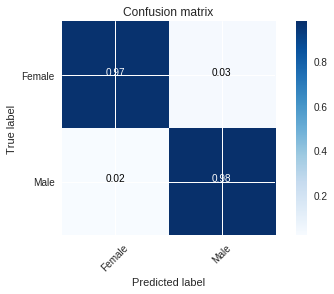

In [28]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['Female', 'Male'], normalize=True)


**Confusion Matrix at epoch 1, 97.47% accuracy:**

[[0.97392735 0.02607265]

 [0.02480559 0.97519441]]

**Epoch 2: Accuracy 97.58**

[[0.97481209 0.02518791]

 [0.02353943 0.97646057]]

**Epoch 3: Accuracy 97.67**

[[0.97453167 0.02546833]

 [0.02165181 0.97834819]]

### Check Mismatched Names

In [0]:
x_test_names = tensor2name(x_test)

In [0]:
test_indexes = np.arange(len(x_test))

In [27]:
mismatch_indexes = test_indexes[y_pred != y_test]
print(mismatch_indexes)

[     1      3      6 ... 909048 909052 909054]


In [28]:
len(mismatch_indexes)/len(x_test)

0.39161656885446977

In [0]:
incorrect_males = {}
incorrect_females = {}
for i in mismatch_indexes:
  if y_pred[i] == 0:
    temp = {}
    temp["name"] = x_test_names[i]
    temp["test"] = y_test[i]
    temp["pred"] = y_pred[i]
    incorrect_males[i] = temp
  else:
    temp = {}
    temp["name"] = x_test_names[i]
    temp["test"] = y_test[i]
    temp["pred"] = y_pred[i]
    incorrect_females[i] = temp

In [30]:
incorrect_males

{17: {'name': '0000000abdullah-al-zubaed', 'pred': 0, 'test': 1},
 80: {'name': '000000000parimal dasgupta', 'pred': 0, 'test': 1},
 115: {'name': '0000000000md. sumon nayeb', 'pred': 0, 'test': 1},
 209: {'name': '0000000000md.masum billam', 'pred': 0, 'test': 1},
 280: {'name': '000000000000niutan dhalee', 'pred': 0, 'test': 1},
 301: {'name': '0000000000md. al mokaddes', 'pred': 0, 'test': 1},
 338: {'name': '000000000jhanntu pada dey', 'pred': 0, 'test': 1},
 341: {'name': '00000000000000ahmed sayem', 'pred': 0, 'test': 1},
 393: {'name': '0000000000md. shazu ahmed', 'pred': 0, 'test': 1},
 405: {'name': '0000000md. hossain ahmmed', 'pred': 0, 'test': 1},
 487: {'name': 'mir muhammad tarekul alam', 'pred': 0, 'test': 1},
 493: {'name': '000000000md khaja ahammad', 'pred': 0, 'test': 1},
 518: {'name': '0000000000000nowagsh alam', 'pred': 0, 'test': 1},
 547: {'name': '000000000md. faruk ahemed', 'pred': 0, 'test': 1},
 575: {'name': '000gouranggha chandra dey', 'pred': 0, 'test': 1

In [31]:
incorrect_females

{1: {'name': '00000000000000sonti mormu', 'pred': 1, 'test': 0},
 3: {'name': '0000000000shimuli tripura', 'pred': 1, 'test': 0},
 6: {'name': '00000000000taposhi barmon', 'pred': 1, 'test': 0},
 8: {'name': '000000000000nazma  parvin', 'pred': 1, 'test': 0},
 12: {'name': '0000000000maya mary toppo', 'pred': 1, 'test': 0},
 22: {'name': '00000000kaniz fatema aniy', 'pred': 1, 'test': 0},
 24: {'name': '0000000zosada rani sarkar', 'pred': 1, 'test': 0},
 27: {'name': '00000kroi sang thui marma', 'pred': 1, 'test': 0},
 30: {'name': '0000000000hosnatul jannat', 'pred': 1, 'test': 0},
 33: {'name': '000000yesmin akter parvin', 'pred': 1, 'test': 0},
 36: {'name': '000000rabeya sultana keya', 'pred': 1, 'test': 0},
 42: {'name': '0000000rabea bosri vhabna', 'pred': 1, 'test': 0},
 43: {'name': '00000000000000000fullbanu', 'pred': 1, 'test': 0},
 46: {'name': '000000000rakha rani sarma', 'pred': 1, 'test': 0},
 48: {'name': '000000000000000sador rini', 'pred': 1, 'test': 0},
 53: {'name': 

In [32]:
print(len(incorrect_males), len(incorrect_females))

22755 333246


# Newspaper Data Processing
To be done in CPU. Load Pickled model and run on CPU.

GPU runtime 4hr, CPU runtime 30 mins.

In [42]:
ls

datalab/             news_db_instance.json  weights-improvement-01-0.9763.hdf5
drive/               news_db.json           weights-improvement-02-0.9767.hdf5
hsc_name_gender.csv  python3mega/


In [43]:
pwd

'/content'

In [0]:
#del char2idx
#del idx2char

In [0]:
#char2idx = {'\t': 0, ' ': 1, '"': 2, "'": 3, '(': 4, ')': 5, '*': 6, '+': 7, '-': 8, '.': 9, '/': 10, '0': 11, '1': 12, '2': 13, '3': 14, '4': 15, '5': 16, '6': 17, '7': 18, '8': 19, '9': 20, ':': 21, ';': 22, '=': 23, '>': 24, '?': 25, '[': 26, '\\': 27, ']': 28, '_': 29, '`': 30, 'a': 31, 'b': 32, 'c': 33, 'd': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'j': 40, 'k': 41, 'l': 42, 'm': 43, 'n': 44, 'o': 45, 'p': 46, 'q': 47, 'r': 48, 's': 49, 't': 50, 'u': 51, 'v': 52, 'w': 53, 'x': 54, 'y': 55, 'z': 56, '{': 57, '|': 58, '}': 59, '\x83': 60, '\x96': 61, '¨': 62, 'ÿ': 63}
#idx2char = {0: '\t', 1: ' ', 2: '"', 3: "'", 4: '(', 5: ')', 6: '*', 7: '+', 8: '-', 9: '.', 10: '/', 11: '0', 12: '1', 13: '2', 14: '3', 15: '4', 16: '5', 17: '6', 18: '7', 19: '8', 20: '9', 21: ':', 22: ';', 23: '=', 24: '>', 25: '?', 26: '[', 27: '\\', 28: ']', 29: '_', 30: '`', 31: 'a', 32: 'b', 33: 'c', 34: 'd', 35: 'e', 36: 'f', 37: 'g', 38: 'h', 39: 'i', 40: 'j', 41: 'k', 42: 'l', 43: 'm', 44: 'n', 45: 'o', 46: 'p', 47: 'q', 48: 'r', 49: 's', 50: 't', 51: 'u', 52: 'v', 53: 'w', 54: 'x', 55: 'y', 56: 'z', 57: '{', 58: '|', 59: '}', 60: '\x83', 61: '\x96', 62: '¨', 63: 'ÿ'}

**Fucntions for processing newspaper data**

In [0]:
import numpy as np
from keras.preprocessing import sequence

# Converts a name into vector
def name2vectorTest(name):
    name = name.lower()
    new_name = ""
    for char in name:
      if char in char2idx:
        new_name += char
    chars = list(new_name)
    vector = [ char2idx[c] for c in chars ]
    return np.array(vector)

# Converts names to fixed size tensor
def names2tensorTest(names, maxlen=25):
    namelist = [name2vectorTest(name) for name in names]
    return sequence.pad_sequences(np.array(namelist), maxlen=maxlen)  # root of all troubles

def nameTest(name):
  result = model.predict_classes(np.array(names2tensorTest([name.lower()])))[0][0]
  if result:
    print("Male")
  else:
    print("Female")

def returnGender(name):
  result = model.predict_classes(np.array(names2tensorTest([name.lower()])))[0][0]
  if result:
    return "Male"
  else:
    return "Female"
  
def isMale(name):
  result = model.predict_classes(np.array(names2tensorTest([name.lower()])))[0][0]
  return result

def genderDictionary(ner_person):
  dictionary = {}
  for name in ner_person:
    dictionary[name] = isMale(name)
  return dictionary

def concatAll(content, ner_person):
  ner_person = sorted(ner_person, key=len, reverse=True)
  for name in ner_person:
    content = content.replace(name, name.replace(" ", ""))
  return content
  
def replaceMaleConcatFemale(content, genderDict):
  ner_person = sorted(genderDict, key=len, reverse=True)
  
  for name in ner_person:
    if genderDict[name] == 0:
      content = content.replace(name, name.replace(" ", ""))
    else:
      content = content.replace(name, "man")
  return content

def replaceFemaleConcatMale(content, genderDict):
  ner_person = sorted(genderDict, key=len, reverse=True)
  
  for name in ner_person:
    if genderDict[name] == 1:
      content = content.replace(name, name.replace(" ", ""))
    else:
      content = content.replace(name, "woman")
  return content

def replaceAll(content, genderDict):
  ner_person = sorted(genderDict, key=len, reverse=True)
  
  for name in ner_person:
    if genderDict[name] == 1:
      content = content.replace(name, "man")
    else:
      content = content.replace(name, "woman")
  return content

**Printing estimated runtime**

In [0]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def diff(t_a, t_b, c):
    t_diff = relativedelta(t_b, t_a)*c  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [33]:
isMale("masuma hasan")

0

Read the crawled newspaper file, and create 4 string with processed data.

In [0]:
import sys
import json

input_text_none = ""
input_text_man = ""
input_text_woman = ""
input_text_both = ""
all_name_set = set()

i = 1
data = "news_db.json"
file_len = 165236
t_a = datetime.now()

with open(data, encoding="utf-8") as file:
  for line in file:
    try:
      i+=1
      parsed_json = json.loads(line)
      
      section = parsed_json["section"]
      if section == "World" or section == "Sports":
        continue
        
      content = parsed_json["content"]
      content += " "
      ner_unique_person = parsed_json["ner_unique_person"]
      all_name_set.update(ner_unique_person)
      genderDict = genderDictionary(ner_unique_person)
      
      input_text_none += concatAll(content, ner_unique_person)
      input_text_man  += replaceMaleConcatFemale(content, genderDict)
      input_text_woman += replaceFemaleConcatMale(content, genderDict)
      input_text_both += replaceAll(content, genderDict)
      
      # PRINT STATUS (print is an expensive function call)
      if i%100==0:
        t_b = datetime.now()
        t_past = diff(t_a, t_b, 1)
        t_remain = diff(t_a, t_b, (file_len-i)/(i+0.000001))
        print( "\r{:.2f}% finished.".format(100*i/(file_len-1)), "\tCurrent Position:", i, 
          "\tTime Elapsed:",t_past, "\tEstimated Remaining Time:",t_remain, end="")

    except Exception as e:
      print("\nException: ", e,"\nSys info: ", sys.exc_info()[0])
      continue
    
file.close()

In [36]:
print(len(input_text_none.split(" ")))
print(len(input_text_man.split(" ")))
print(len(input_text_woman.split(" ")))
print(len(input_text_both.split(" ")))
print(len(all_name_set))

3182
3182
3182
3182
26


In [37]:
print("normal: ", input_text_none[0:50])
print("Male name replaced: ", input_text_man[0:50])
print("Female name replaced: ", input_text_woman[0:50])
print("Both name replaced: ", input_text_both[0:10])
print("Unique names: ", list(all_name_set)[0:4])

normal:  From guiding you on using the right equipment in g
Male name replaced:  From guiding you on using the right equipment in g
Female name replaced:  From guiding you on using the right equipment in g
Both name replaced:  From guidi
Unique names:  ['Banani', 'Sidr', 'Abbas', 'Bangla Bhai']


In [0]:
nonGender = open("nonGender.txt", "w")
maleReplaced = open("maleReplaced.txt", "w")
femaleReplaced = open("femaleReplaced.txt", "w")
bothReplaced = open("bothReplaced.txt", "w")
uniqueNames = open("uniqueNames.txt", "w")

In [0]:
nonGender.write(input_text_none)
maleReplaced.write(input_text_man)
femaleReplaced.write(input_text_woman)
bothReplaced.write(input_text_both)

nonGender.close()
maleReplaced.close()
femaleReplaced.close()
bothReplaced.close()

In [0]:
for item in all_name_set:
  item_gender = returnGender(item)
  trunc_item = item.replace(" ", "")
  uniqueNames.write("{}\t-\t{}\n".format(trunc_item, item_gender))
  
uniqueNames.close()

In [0]:
%%bash
mkdir -p drive/data/newspaper_text/

cp nonGender.txt drive/data/newspaper_text/
cp maleReplaced.txt drive/data/newspaper_text/
cp femaleReplaced.txt drive/data/newspaper_text/
cp bothReplaced.txt drive/data/newspaper_text/
cp uniqueNames.txt drive/data/newspaper_text/

In [42]:
nameTest("Khaleda Zia")

Female


### File analytics

In [0]:
none_set = set(input_text_none.split(" "))
man_set = set(input_text_man.split(" "))
woman_set = set(input_text_woman.split(" "))
both_set = set(input_text_both.split(" "))

In [0]:
intersection = set.intersection(none_set, man_set, woman_set, both_set)
len(intersection)

1185696

In [0]:
print(len(none_set), len(man_set), len(woman_set), len(both_set))

1518332 1300252 1438363 1217811


### Pickle this 5 sets

**Save Pickle**

In [0]:
import pickle

with open('none_set.pickle', 'wb') as handle:
    pickle.dump(none_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('man_set.pickle', 'wb') as handle:
    pickle.dump(man_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('woman_set.pickle', 'wb') as handle:
    pickle.dump(woman_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('both_set.pickle', 'wb') as handle:
    pickle.dump(both_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('intersection.pickle', 'wb') as handle:
    pickle.dump(intersection, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
ls -l

total 1701272
-rw-r--r-- 1 root root 227822867 Aug  8 02:50 bothReplaced.txt
-rw-r--r-- 1 root root  16746298 Aug  8 03:56 both_set.pickle
-rw-r--r-- 1 root root      1954 Aug  8 02:05 cse13_names.txt
drwxr-xr-x 1 root root      4096 Aug  8 02:03 datalab/
drwxr-xr-x 2 root root      4096 Aug  8 02:03 drive/
-rw-r--r-- 1 root root 233136902 Aug  8 02:50 femaleReplaced.txt
-rw-r--r-- 1 root root        32 Aug  8 03:40 filename.pickle
-rw-r--r-- 1 root root  58668225 Aug  8 02:05 hsc_unique.csv
-rw-r--r-- 1 root root  16253493 Aug  8 03:56 intersection.pickle
-rw-r--r-- 1 root root 228913277 Aug  8 02:50 maleReplaced.txt
-rw-r--r-- 1 root root  18079100 Aug  8 03:56 man_set.pickle
-rw-r--r-- 1 root root   1915057 Aug  8 02:04 model.pickle
-rw-r--r-- 1 root root     27174 Aug  8 02:06 news_db_instance.json
-rw-r--r-- 1 root root 658608032 Aug  8 02:06 news_db.json
-rw-r--r-- 1 root root  22017202 Aug  8 03:56 none_set.pickle
-rw-r--r-- 1 root root 234264261 Aug  8 02:50 nonGender.txt
-rw-r

In [0]:
%%bash
mkdir -p drive/data/analytics/

cp *.pickle drive/data/analytics/

In [0]:
cp woman_set.pickle drive/data/analytics/

**Load Pickled data**

In [0]:
!cp drive/data/newspaper_text/analytics/*.pickle ./

In [0]:
import pickle

with open('none_set.pickle', 'rb') as handle:
    none_set = pickle.load(handle)
with open('man_set.pickle', 'rb') as handle:
    man_set = pickle.load(handle)
with open('woman_set.pickle', 'rb') as handle:
    woman_set = pickle.load(handle)
with open('both_set.pickle', 'rb') as handle:
    both_set = pickle.load(handle)
with open('intersection.pickle', 'rb') as handle:
    intersection = pickle.load(handle)